In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST,CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

**Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**HelperFunction**

In [16]:
def show_tensor_images(image_tensor, num_images=16, size=(1, 28, 28), nrow=3):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

**Generator**

In [4]:
def make_gen_block(input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
            nn.Tanh(),
        )

class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            make_gen_block(z_dim, hidden_dim * 4),
            make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            make_gen_block(hidden_dim * 2, hidden_dim),
            make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

**Classifier**

In [5]:
def make_classifier_block(input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
    if final_layer:
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride),
        )
    else:
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

class Classifier(nn.Module):
    def __init__(self, im_chan=1, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            make_classifier_block(im_chan, hidden_dim),
            make_classifier_block(hidden_dim, hidden_dim * 2),
            #make_classifier_block(hidden_dim * 2, hidden_dim * 2, stride=3),
            make_classifier_block(hidden_dim * 2, n_classes, final_layer=True),
        )

    def forward(self, image):
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

**Initialzie Component**

In [9]:
#hyper_parameter
z_dim = 64
batch_size = 128
device = 'cuda'

#classifier_parameter
label_indices = range(10)

n_epochs = 5
display_step = 500
lr = 0.001
beta_1 = 0.5
beta_2 = 0.999
image_size = 28

#generator_parameter


**Train classifier**

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", train = True,download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Classifier loss: 0.040668765729293226


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


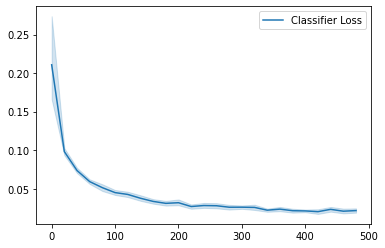

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Classifier loss: 0.016900726388208567


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


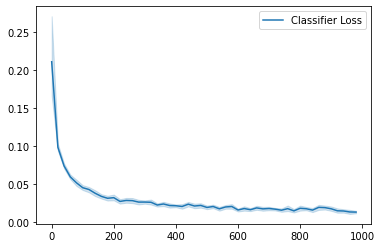

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3, step 1500: Classifier loss: 0.013133905170485377


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


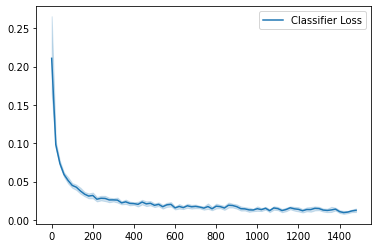

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4, step 2000: Classifier loss: 0.011271402179729193


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


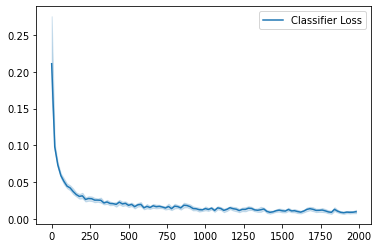

In [10]:
classifier = Classifier(n_classes=len(label_indices)).to(device)
class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()

cur_step = 0
classifier_losses = []

for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, labels in tqdm(dataloader):
        real = real.to(device)
        labels = nn.functional.one_hot(labels.to(device),10).float()
        #labels = labels[:, label_indices].to(device).float()
       
        class_opt.zero_grad()
        class_pred = classifier(real)
        #class_pred = F.softmax(class_pred)
        class_loss = criterion(class_pred, labels)
        class_loss.backward() # Calculate the gradients
        class_opt.step() # Update the weights
        classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

        if cur_step % display_step == 0 and cur_step > 0:
           class_mean = sum(classifier_losses[-display_step:]) / display_step
           print(f"Epoch {epoch}, step {cur_step}: Classifier loss: {class_mean}")
           step_bins = 20
           x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
           sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
           plt.legend()
           plt.show()
           #torch.save({"classifier": classifier.state_dict()}, filename)
        cur_step += 1

**load generator**

In [14]:
gen = Generator(z_dim).to(device)
gen_dict = torch.load("/content/drive/MyDrive/Generative In Action/ImplicitModel/GAN/src/CGAN-config/pretrained_generator_WP.pth", map_location=torch.device(device))["generator"]
gen.load_state_dict(gen_dict)
gen.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)

**Training**

In [18]:
def caculated_updated_noise(noise,weight):
    noise = noise + noise.grad * weight
    return noise

In [19]:
classifier = classifier.eval()
gen = gen.eval()

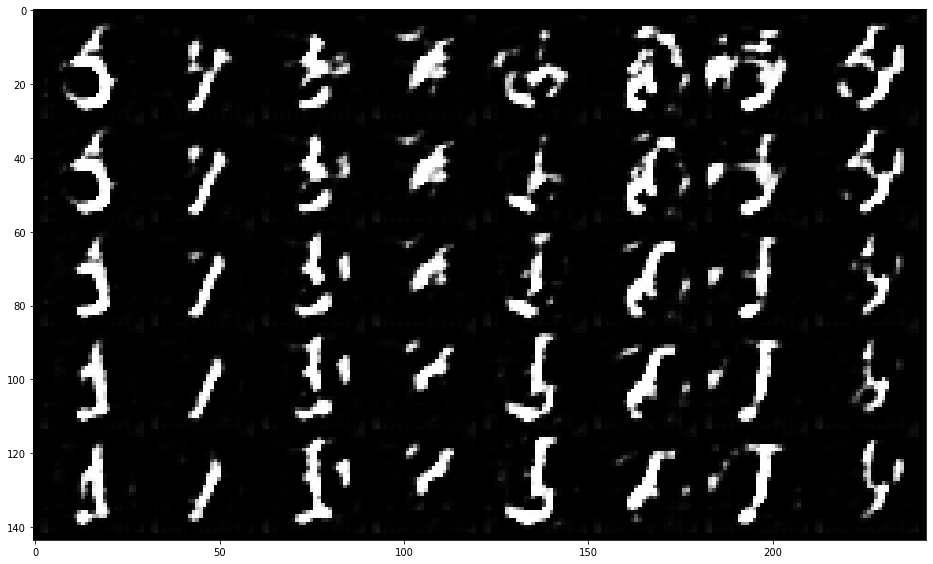

In [21]:
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["0","1","2","3","4","5","6","7","8","9"]
target_indices = feature_names.index("1") # Feel free to change this value to any string from feature_names!
opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

noise = get_noise(n_images, z_dim).to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = caculated_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

**Entanglement and Regularization**

In [22]:
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
    other_distances = current_classifications[:,other_indices] - original_classifications[:,other_indices]
    other_class_penalty = -torch.norm(other_distances, dim=1).mean() * penalty_weight
    target_score = current_classifications[:, target_indices].mean()
    
    return target_score + other_class_penalty

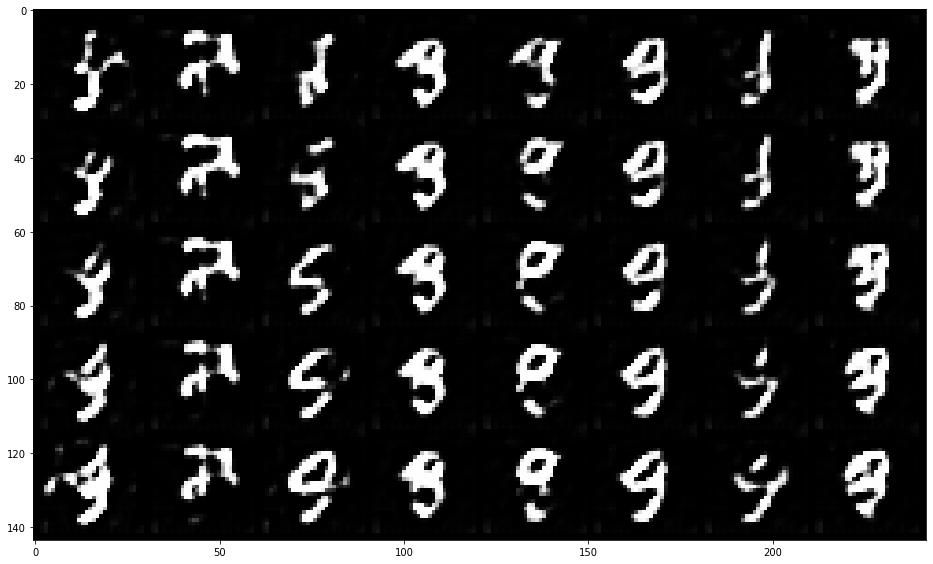

In [24]:
fake_image_history = []
### Change me! ###
target_indices = feature_names.index("9") # Feel free to change this value to any string from feature_names from earlier!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()
for i in range(10):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake), 
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = caculated_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)